<a href="https://colab.research.google.com/github/anishkahc/ML-Fall-23/blob/main/MLTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
import optuna

In [ ]:
#Get Data from Colab
drive.mount('/content/drive')
df_raw = pd.read_csv('/content/drive/MyDrive/data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-22-918e7b36ddef>:3: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/content/drive/MyDrive/data.csv')


In [ ]:
#Initial Viewing
df_raw.columns
df_raw.shape

(855969, 73)

In [ ]:
#Dropping Columns which are not available at post-origination
df = df_raw[df_raw['purpose']=='credit_card'].copy()
columns_to_drop = [
    'issue_d',                 #Date the loan was funded (post-origination)
    'out_prncp',               #Remaining outstanding principal (post-origination)
    'out_prncp_inv',           #Remaining outstanding principal funded by investors (post-origination)
    'total_pymnt',             #Total payments received to date (post-origination)
    'total_pymnt_inv',         #Total payments received to date for the portion funded by investors (post-origination)
    'total_rec_prncp',         #Principal received to date (post-origination)
    'total_rec_int',           #Interest received to date (post-origination)
    'total_rec_late_fee',      #Late fees received (post-origination)
    'recoveries',              #Amount recovered post charge-off (post-origination)
    'collection_recovery_fee', #Fees associated with collecting post charge-off recoveries (post-origination)
    'last_pymnt_d',            #Date of the last payment (post-origination)
    'last_pymnt_amnt',         #Amount of the last payment received (post-origination)
    'next_pymnt_d',            #Date of the next scheduled payment (future-oriented)
    'desc',
    'emp_title',
    'purpose',
    'title',
]

df=df.drop(columns_to_drop,axis=1)


In [ ]:
df.shape

(200144, 56)

In [ ]:
#Checking null % of columns
pd.DataFrame(df.isnull().mean())

,0
id,0.000000
member_id,0.000000
loan_amnt,0.000000
funded_amnt,0.000000
funded_amnt_inv,0.000000
term,0.000000
int_rate,0.000000
installment,0.000000
grade,0.000000
sub_grade,0.000000


In [ ]:
#Dropping Columns with more than 90% null values
threshold = 0.9
df = df[df.columns[df.isnull().mean() < threshold]]

In [ ]:
df.shape

(200144, 39)

In [ ]:
#Imputing missing values by Median
num_imputer = SimpleImputer(strategy='median')
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = num_imputer.fit_transform(df[num_cols])

In [ ]:
#Imputing Categorical Values with the most frequent ones
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [ ]:
#converting dates columns available to number of days
for col in ['earliest_cr_line', 'last_credit_pull_d']:
    df[col] = pd.to_datetime(df[col])
    df[col + '_days'] = (pd.to_datetime('2023-12-07') - df[col]).dt.days
    df.drop(col, axis=1, inplace=True)


In [ ]:
#Converting non cat features to float
categorical_features = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan',  'zip_code', 'addr_state', 'initial_list_status', 'application_type']
for col in list(set(list(df.columns)) - set(categorical_features)):
  df[col] = df[col].astype("float64")

In [ ]:
#Converting Cat (objects) to Cat(Category)
for col in categorical_features:
    df[col] = df[col].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200144 entries, 0 to 855968
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   id                           200144 non-null  float64 
 1   member_id                    200144 non-null  float64 
 2   loan_amnt                    200144 non-null  float64 
 3   funded_amnt                  200144 non-null  float64 
 4   funded_amnt_inv              200144 non-null  float64 
 5   term                         200144 non-null  category
 6   int_rate                     200144 non-null  float64 
 7   installment                  200144 non-null  float64 
 8   grade                        200144 non-null  category
 9   sub_grade                    200144 non-null  category
 10  emp_length                   200144 non-null  category
 11  home_ownership               200144 non-null  category
 12  annual_inc                   200144 non-null

In [ ]:
#Initialising X and Y
X = df.drop(['default_ind', 'id', 'member_id'], axis=1)
y = df['default_ind']

In [ ]:
#Splitting the data set into train, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify = y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=123)

# Logistic Regression

In [ ]:
#Selecting numerical and categorical columns for preprocessing
#'num_cols' will have all columns with data types 'int64' and 'float64'
#'cat_cols' will have all columns with data types 'object' and 'category'
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns


#'StandardScaler' is used to scale numerical features to have mean=0 and variance=1
#'OneHotEncoder' is used to convert categorical variables into 1 hot encoding columns
#'handle_unknown='ignore'' ensures that if a category in test data is not found in training data, it won't throw an error
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

#Transforming the training and test datasets using the defined preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#Initializing and fitting the Logistic Regression model
#'class_weight='balanced'' is used to handle class imbalance by adjusting weights inversely proportional to class frequencies

log_reg = LogisticRegression(class_weight='balanced', random_state=123)
log_reg.fit(X_train_transformed, y_train)
y_pred_lr = log_reg.predict(X_test_transformed)

#Evaluating the model using accuracy and ROC AUC score
#Accuracy is the proportion of correctly predicted observations
#ROC AUC score is the area under the ROC curve and evaluates the model's ability to distinguish between classes
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

print("Logistic Regression - Test Accuracy:", accuracy_lr)
print("Logistic Regression - Test ROC AUC:", roc_auc_lr)

Logistic Regression - Test Accuracy: 0.7740694479140644
Logistic Regression - Test ROC AUC: 0.745764376788967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# LightGBM

In [ ]:
def objective(trial):
    #Parameters to be tuned by Optuna
    #'trial.suggest_float' and 'trial.suggest_int' are used to suggest values for each hyperparameter
    param = {
        'objective': 'binary',                     #Objective function for binary classification
        'metric': 'binary_logloss',                #Metric for binary classification
        'verbosity': -1,                           #Verbosity of LightGBM
        'boosting_type': 'gbdt',                   #Boosting type, here Gradient Boosting Decision Tree
        'class_weight': 'balanced',                #For handling class imbalance
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  #Learning rate for training
        'max_depth': trial.suggest_int('max_depth', 3, 15),               #Max depth of trees
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),           #Number of leaves in full trees
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)      #Number of boosting iterations
    }

    #Initialize and fit the LightGBM model with the suggested parameters
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    #Predict probabilities on the validation set and calculate ROC AUC score
    preds = gbm.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    return roc_auc

#Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

#Best hyperparameters
best_params = study.best_params
best_gbm = lgb.LGBMClassifier(**best_params)
best_gbm.fit(X_train, y_train)

#Evaluate the final model
y_pred = best_gbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


[I 2023-12-08 08:42:49,097] A new study created in memory with name: no-name-74987d5f-e46a-4210-8b2a-c388b93a19cc
[I 2023-12-08 08:43:30,183] Trial 0 finished with value: 0.7938114303950643 and parameters: {'learning_rate': 0.06980363330020166, 'max_depth': 9, 'num_leaves': 109, 'n_estimators': 727}. Best is trial 0 with value: 0.7938114303950643.
[I 2023-12-08 08:44:14,632] Trial 1 finished with value: 0.7921499394085163 and parameters: {'learning_rate': 0.03909789446001744, 'max_depth': 11, 'num_leaves': 65, 'n_estimators': 802}. Best is trial 0 with value: 0.7938114303950643.
[I 2023-12-08 08:44:46,184] Trial 2 finished with value: 0.804929984550998 and parameters: {'learning_rate': 0.042756497630726954, 'max_depth': 7, 'num_leaves': 149, 'n_estimators': 677}. Best is trial 2 with value: 0.804929984550998.
[I 2023-12-08 08:45:37,148] Trial 3 finished with value: 0.795482221612004 and parameters: {'learning_rate': 0.0463052982323346, 'max_depth': 8, 'num_leaves': 107, 'n_estimators':

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5641, number of negative: 134459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4772
[LightGBM] [Info] Number of data points in the train set: 140100, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040264 -> initscore=-3.171198
[LightGBM] [Info] Start training from score -3.171198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
num_features = best_gbm.n_features_

#Names of the features used in the model
feature_names = best_gbm.feature_name_

print("Number of features used:", num_features)
print("Features used in the LightGBM model:", feature_names)

Number of features used: 36
Features used in the LightGBM model: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'earliest_cr_line_days', 'last_credit_pull_d_days']


In [ ]:
print("Best Hyperparameters for LightGBM:", best_params)
print("LightGBM - Test Accuracy:", accuracy)
print("LightGBM - Test ROC AUC:", roc_auc)

Best Hyperparameters for LightGBM: {'learning_rate': 0.03459986834785, 'max_depth': 3, 'num_leaves': 65, 'n_estimators': 681}
LightGBM - Test Accuracy: 0.9598800899325506
LightGBM - Test ROC AUC: 0.5119015092375747


# Summary Table and Graphs

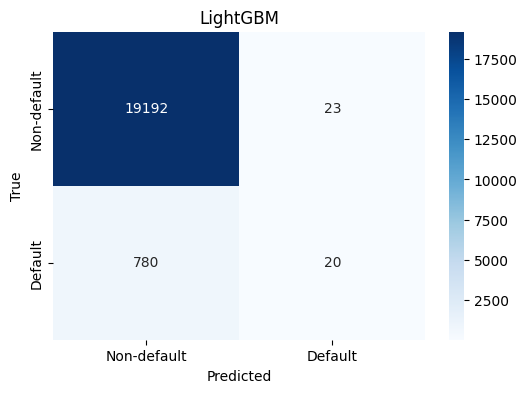

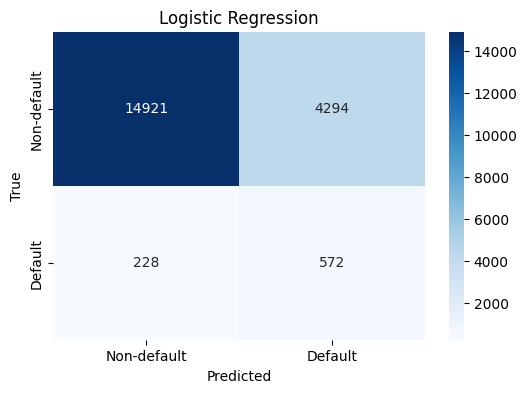

,Model,Accuracy,ROC-AUC Score,Precision (Non-default),Recall (Non-default),F1-score (Non-default),Precision (Default),Recall (Default),F1-score (Default)
0,LightGBM,0.959880,0.511902,0.960945,0.998803,0.979509,0.465116,0.025,0.047450
1,Logistic Regression,0.774069,0.745764,0.984950,0.776529,0.868409,0.117550,0.715,0.201906


In [ ]:
def evaluate_predictions(y_true, y_pred, model_name):
    #Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    #Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    #Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    #Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    #Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table


lgbm = evaluate_predictions(y_test, y_pred, "LightGBM")
lr = evaluate_predictions(y_test, y_pred_lr, "Logistic Regression")
#Combine the summaries into one DataFrame
combined_summary = pd.concat([lgbm, lr], ignore_index=True)

#Display the combined summary
combined_summary.head()